# This is just a notebook to visualise 1kHz filtered raw data

## Setup everything

### Import packages

In [38]:
import os
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
from open_ephys.analysis import Session

import mmap
import xarray as xr
import dask.array as da
#%matplotlib widget


from ephyviewer import mkQApp, MainViewer, TraceViewer

from ipyfilechooser import FileChooser

### Define mapping dict

canalMap is a dictionary with one key per brain region and/or canal of interest (TTL). The value associated to the key is an array with every corresponding canal. The "status" key defines which of these canals to use for analyses:
- 0: not to use
- 1 only: floating point canal
- 1 and 2: differential signal 2-1

In [2]:
canalMap = dict( \
    EMG = [dict(canal = 6, status=1)],
    PFC = [dict(canal = 5, status=1),
           dict(canal = 4, status=2)
           ],
    CA1 = [dict(canal = 8, status=1),
           dict(canal = 0, status=0),
           dict(canal = 1, status=0),
        ],
    TTL = [dict(canal = 10, status=1)],
)

### Define functions

#### Read data file

In [3]:
def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d

#### Choose path

In [32]:
expePath = None
subpath4FPGA = None
fileBaseName = None

%store -r expePath subpath4FPGA fileBaseName
if expePath is None:
    expePath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/"
    print("The experiment path is not in strore yet, setting it to default: {}".format(expePath))

if subpath4FPGA is None:
    subpath4FPGA = "recording8/continuous/Rhythm_FPGA-133.0/"
    print("The experiment path is not in strore yet, setting it to default: {}".format(subpath4FPGA))

if fileBaseName is None:
    fileBaseName = "continuous.dat"
    print("The experiment path is not in strore yet, setting it to default: {}".format(fileBaseName))


fc = FileChooser(path=os.path.join(expePath,subpath4FPGA), filename=fileBaseName,select_default=True, show_only_dirs = False, title = "<b>ePhys data</b>")
display(fc)

# Sample callback function
def update_my_folder(chooser):
    global expePath, subpath4FPGA, fileBaseName
    filePath = chooser.selected
    subpath4FPGA = ""
    fileBaseName = os.path.basename(filePath)
    print("Storing filename: {}".format(fileBaseName))
    level=4
    for i in range(level):
        filePath = os.path.dirname(filePath)
        if i < level-1:
            subpath4FPGA = os.path.basename(filePath) + "/" + subpath4FPGA
    expePath = filePath
    print("Storing experiement path: {}".format(expePath))
    print("Storing subpath: {}".format(subpath4FPGA))
    %store expePath subpath4FPGA fileBaseName
    return 

# Register callback function
fc.register_callback(update_my_folder)

FileChooser(path='/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/recording8/continuous/Rhythm_FPGA-133.0', file…

## Load Data

### Map the whole data into memory

In [46]:
filename = os.path.join(expePath,subpath4FPGA,fileBaseName)
All = np.memmap(filename, mode='r', dtype='int16')

#self.samples = All.reshape((len(All) // self.metadata['num_channels'], 
#                                         self.metadata['num_channels']))


### Extract submatrix of interest

In [ ]:
EMG = All2[:, 6]
PFC1 = All2[:, 5]
PFC2 = All2[:, 4]
PFC = PFC2 - PFC1
CA11 = All[:, 0]
CA12 = All[:, 1]
TTL = All2[:, 10]
CA1 = All2[:, 8]

EMG = EMG[:, np.newaxis]
PFC = PFC[:, np.newaxis]
CA1 = CA1[:, np.newaxis]
CA11 = CA11[:, np.newaxis]
CA12 = CA12[:, np.newaxis]
TTL = TTL[:, np.newaxis]


combined = np.append(EMG, PFC, axis=1)
combined = np.append(combined, CA1, axis=1)
combined = np.append(combined, CA11, axis=1)
combined = np.append(combined, CA12, axis=1)
combined = np.append(combined, TTL, axis=1)


In [ ]:
filenameT = folder_base / f'timestamps2.npy'
Timestamps = np.load(filenameT)
Timestamps.shape
Timestamps = Timestamps*2000
#Timestamps = int(Timestamps)
Timestamps = Timestamps.astype(int)
Timestamps

array([127248, 127248, 127268, 127268, 127348, 127348, 127368, 127368,
       127448, 127448, 127468, 127468, 127548, 127548, 127568, 127568,
       127648, 127648, 127668, 127668, 127748, 127748, 127768, 127768,
       127848, 127848, 127868, 127868, 158913, 158913, 158933, 158933,
       159013, 159013, 159033, 159033, 159113, 159113, 159133, 159133,
       159213, 159213, 159233, 159233, 159313, 159313, 159333, 159333,
       159413, 159413, 159433, 159433, 159513, 159513, 159533, 159533,
       190478, 190478, 190498, 190498, 190578, 190578, 190598, 190598,
       190678, 190678, 190698, 190698, 190778, 190778, 190798, 190798,
       190878, 190878, 190898, 190898, 190978, 190978, 190998, 190998,
       191078, 191078, 191098, 191098, 222077, 222077, 222097, 222097,
       222177, 222177, 222197, 222197, 222277, 222277, 222297, 222297,
       222377, 222377, 222397, 222397, 222477, 222477, 222497, 222497,
       222577, 222577, 222597, 222597, 222677, 222677, 222697, 222697,
      

In [ ]:
EMG = All[:, 0]
PFC1 = All[:, 5]
PFC2 = All[:, 6]
PFC = PFC2 - PFC1
C1 = All[:, 7]
C2 = All[:, 8]
Cx = C2 - C1
S11 = All[:, 1]
S12 = All[:, 2]
S1 = S12 - S11
CA11 = All[:, 9]
CA12 = All[:, 10]
CA1 = CA12 - CA11
TTL = All[:, 11]
V1 = All[:, 7]

EMG = EMG[:, np.newaxis]
PFC1 = PFC1[:, np.newaxis]
PFC2 = PFC2[:, np.newaxis]
PFC = PFC[:, np.newaxis]
C1 = C1[:, np.newaxis]
C2 = C2[:, np.newaxis]
Cx = Cx[:, np.newaxis]
S11 = S11[:, np.newaxis]
S12 = S12[:, np.newaxis]
S1 = S1[:, np.newaxis]
CA11 = CA11[:, np.newaxis]
CA12 = CA12[:, np.newaxis]
CA1 = CA1[:, np.newaxis]
TTL = TTL[:, np.newaxis]
V1 = V1[:, np.newaxis]


combined = np.append(EMG, PFC1, axis=1)
combined = np.append(combined, PFC2, axis=1)
combined = np.append(combined, PFC, axis=1)
combined = np.append(combined, C1, axis=1)
combined = np.append(combined, C2, axis=1)
combined = np.append(combined, Cx, axis=1)
combined = np.append(combined, CA11, axis=1)
combined = np.append(combined, CA12, axis=1)
combined = np.append(combined, CA1, axis=1)


In [ ]:
EMG = All[:, 0]#5
CA1r = All[:, 9] - All[:, 10]# 1-2
CA1l = All[:, 7] - All[:, 8]# 0-8
CA1l1 = All[:, 22]#0
CA1l2 = All[:, 23]#8
CA1r1 = All[:, 5]#2
CA1r2 = All[:, 6]#1
EMG = EMG[:, np.newaxis]
CA1r = CA1r[:, np.newaxis]
CA1r1 = CA1r1[:, np.newaxis]
CA1r2 = CA1r2[:, np.newaxis]
CA1l = CA1l[:, np.newaxis]
CA1l1 = CA1l1[:, np.newaxis]
CA1l2 = CA1l2[:, np.newaxis]
combined = np.append(EMG, CA1r1, axis=1)
combined = np.append(combined, CA1r2, axis=1)
combined = np.append(combined, CA1r, axis=1)
combined = np.append(combined, CA1l1, axis=1)
combined = np.append(combined, CA1l2, axis=1)
combined = np.append(combined, CA1l, axis=1)

In [ ]:


app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'


view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00004
view1.by_channel_params['ch2', 'gain'] = 0.00004
view1.by_channel_params['ch3', 'gain'] = 0.00005
view1.by_channel_params['ch4', 'gain'] = 0.00005

view1.by_channel_params['ch0', 'offset'] = 0.1
view1.by_channel_params['ch1', 'offset'] = 0.05
view1.by_channel_params['ch2', 'offset'] = -0.0
view1.by_channel_params['ch3', 'offset'] = -0.05
view1.by_channel_params['ch4', 'offset'] = -0.1

#Run
win.show()
app.exec_()

NameError: name 'mkQApp' is not defined

In [ ]:
combined.shape

(828811, 6)

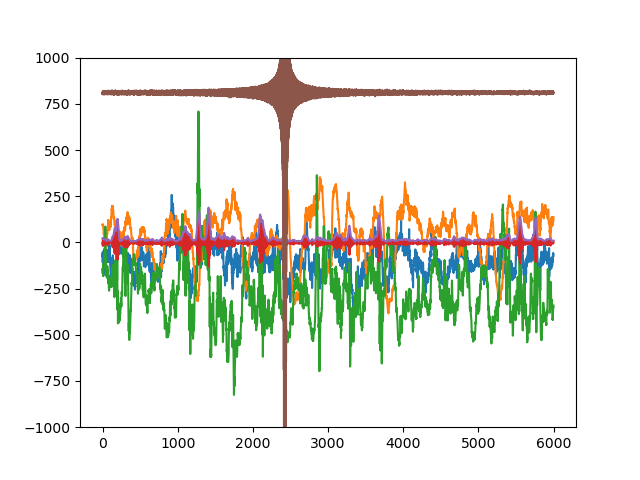

: 

In [ ]:
combined2 = combined[363000:369000,:]
#times = np.arange(0, 2000/2000, 1./2000)
#tt = times[363000:369000]
Cortext = combined2

plt.close('all')
plt.plot(Cortext)
plt.ylim((-1000,1000))

filename = folder_base / f'extract.svg'
plt.savefig(filename, format="svg")

In [ ]:


app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#ff5500'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch7', 'color'] = '#0055ff'
view1.by_channel_params['ch8', 'color'] = '#0055ff'

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00004
view1.by_channel_params['ch2', 'gain'] = 0.00004
view1.by_channel_params['ch3', 'gain'] = 0.00005
view1.by_channel_params['ch4', 'gain'] = 0.00006
view1.by_channel_params['ch5', 'gain'] = 0.00006
view1.by_channel_params['ch6', 'gain'] = 0.00003
view1.by_channel_params['ch7', 'gain'] = 0.00006
view1.by_channel_params['ch8', 'gain'] = 0.00003

view1.by_channel_params['ch0', 'offset'] = 0.4
view1.by_channel_params['ch1', 'offset'] = 0.3
view1.by_channel_params['ch2', 'offset'] = 0.2
view1.by_channel_params['ch3', 'offset'] = 0.1
view1.by_channel_params['ch4', 'offset'] = -0.0
view1.by_channel_params['ch5', 'offset'] = -0.1
view1.by_channel_params['ch6', 'offset'] = -0.2
view1.by_channel_params['ch7', 'offset'] = -0.3
view1.by_channel_params['ch8', 'offset'] = -0.4

#Run
win.show()
app.exec_()

: 

Visualise All

In [ ]:
start = 000000
end = len(EMG)
EMGs = EMG[start:end, np.newaxis]
PFC1s = PFC1[start:end, np.newaxis]
PFC2s = PFC2[start:end, np.newaxis]
PFCs = PFC[start:end, np.newaxis]
S11s = S11[start:end, np.newaxis]
S12s = S12[start:end, np.newaxis]
S1s = S1[start:end, np.newaxis]
CA11s = CA11[start:end, np.newaxis]
CA12s = CA12[start:end, np.newaxis]
#CA13s = CA13[start:end, np.newaxis]
CA1s = CA1[start:end, np.newaxis]
#CA1s2 = CA1b[start:end, np.newaxis]
#CA1s3 = CA1c[start:end, np.newaxis]
combined = np.append(EMGs, PFC1s, axis=1)
combined = np.append(combined, PFC2s, axis=1)
combined = np.append(combined, PFCs, axis=1)
combined = np.append(combined, S12s, axis=1)
combined = np.append(combined, S11s, axis=1)
combined = np.append(combined, S1s, axis=1)
combined = np.append(combined, CA11s, axis=1)
combined = np.append(combined, CA12s, axis=1)
combined = np.append(combined, CA1s, axis=1)


In [ ]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#ff5500'
view1.by_channel_params['ch5', 'color'] = '#ff5500'
view1.by_channel_params['ch7', 'color'] = '#9b3b70'
view1.by_channel_params['ch8', 'color'] = '#9b3b70'
#view1.by_channel_params['ch9', 'color'] = '#9b3b70'

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00006
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00003
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002

view1.by_channel_params['ch0', 'offset'] = 0.5
view1.by_channel_params['ch1', 'offset'] = 0.4
view1.by_channel_params['ch2', 'offset'] = 0.3
view1.by_channel_params['ch3', 'offset'] = 0.2
view1.by_channel_params['ch4', 'offset'] = 0.1
view1.by_channel_params['ch5', 'offset'] = 0
view1.by_channel_params['ch6', 'offset'] = -0.1
view1.by_channel_params['ch7', 'offset'] = -0.2
view1.by_channel_params['ch8', 'offset'] = -0.3
view1.by_channel_params['ch9', 'offset'] = -0.4

#Run
win.show()
app.exec_()

NameError: name 'combined' is not defined

In [ ]:
print(len(EMG))

Visualise subset

In [ ]:

start = 000000
end = len(S1)
S1s = S1[start:end, np.newaxis]
S1as = S1a[start:end, np.newaxis]
S1bs = S1b[start:end, np.newaxis]

combined = np.append(S1s, S1as, axis=1)
combined = np.append(combined, S1bs, axis=1)
#combined = np.append(combined, PFC2s, axis=1)
#combined = np.append(combined, PFCs, axis=1)
#combined = np.append(combined, S12s, axis=1)
#combined = np.append(combined, S11s, axis=1)
#combined = np.append(combined, S1s, axis=1)
#combined = np.append(combined, S1s, axis=1)
#combined = np.append(combined, CA11s, axis=1)
# combined = np.append(combined, CA12s, axis=1)
# combined = np.append(combined, CA13s, axis=1)
# combined = np.append(combined, CA1s, axis=1) #CA12 - CA11
# combined = np.append(combined, CA1s2, axis=1) #CA13 - CA11
# combined = np.append(combined, CA1s3, axis=1) #CA13 - CA12
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#9b3b70'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
#view1.by_channel_params['ch5', 'color'] = '#ff5500'
#view1.by_channel_params['ch2', 'color'] = '#9b3b70'
#view1.by_channel_params['ch3', 'color'] = '#9b3b70'
#view1.by_channel_params['ch3', 'color'] = '#9b3b70'
#view1.by_channel_params['ch4', 'color'] = '#9b3b70'



view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00001
view1.by_channel_params['ch2', 'gain'] = 0.00001
# view1.by_channel_params['ch3', 'gain'] = 0.00001
# view1.by_channel_params['ch4', 'gain'] = 0.00002
# view1.by_channel_params['ch5', 'gain'] = 0.00002
# #view1.by_channel_params['ch5', 'gain'] = 0.00003
# view1.by_channel_params['ch6', 'gain'] = 0.00002
# view1.by_channel_params['ch7', 'gain'] = 0.00001
# view1.by_channel_params['ch8', 'gain'] = 0.00001
# view1.by_channel_params['ch9', 'gain'] = 0.00005

view1.by_channel_params['ch0', 'offset'] = 0.3
view1.by_channel_params['ch1', 'offset'] = 0.
view1.by_channel_params['ch2', 'offset'] = -0.3
# view1.by_channel_params['ch3', 'offset'] = -0.
# view1.by_channel_params['ch4', 'offset'] = -0.1
# view1.by_channel_params['ch5', 'offset'] = -0.2
# #view1.by_channel_params['ch5', 'offset'] = -0.2
# view1.by_channel_params['ch6', 'offset'] = -0.3
# view1.by_channel_params['ch7', 'offset'] = -0.2
# view1.by_channel_params['ch8', 'offset'] = -0.3
# view1.by_channel_params['ch9', 'offset'] = -0.4

#Run
win.show()
app.exec_()

0

In [ ]:
# folder_base = Path('Gaelle/Baseline_recording/GreenLinesOK/session3/OpenEphys/')
folder_base = Path('/Users/ahay/Documents/DATA/DREADDthalamus/JessyTest/2201/')

filename = folder_base / f'RawDataChannelExtractedDS.npy'
filename2 = folder_base / f'RawDataChannelExtractedDS.npy'

All = np.load(filename2, mmap_mode= 'r')
All0 = np.load(filename, mmap_mode= 'r')
combined0 = All[3000000:4000000,22:26].copy()
combined1 = All0[3000000:4000000:,20:22].copy()
combined11 = All0[3000000:4000000:,26:28].copy()
combined12 = All0[3000000:4000000:,0:2].copy()
combined13 = All0[3000000:4000000:,14:16].copy()
combined14 = All0[3000000:4000000:,2:4].copy()
combined15 = All0[3000000:4000000:,12:14].copy()
combined21 = np.append(combined0, combined1, axis=1)
combined22 = np.append(combined21, combined11, axis=1)
combined23 = np.append(combined22, combined12, axis=1)
combined24 = np.append(combined23, combined13, axis=1)
combined25 = np.append(combined24, combined14, axis=1)
combined2 = np.append(combined25, combined15, axis=1)
All.shape
All2 = All.copy()
All2 = All2.T
All2.shape

In [ ]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00012
view1.by_channel_params['ch1', 'gain'] = 0.00012
view1.by_channel_params['ch2', 'gain'] = 0.00012
view1.by_channel_params['ch3', 'gain'] = 0.00012
view1.by_channel_params['ch4', 'gain'] = 0.00012
view1.by_channel_params['ch5', 'gain'] = 0.00012
view1.by_channel_params['ch6', 'gain'] = 0.00012
view1.by_channel_params['ch7', 'gain'] = 0.00012
view1.by_channel_params['ch8', 'gain'] = 0.00012
view1.by_channel_params['ch9', 'gain'] = 0.00012
view1.by_channel_params['ch10', 'gain'] = 0.00012
view1.by_channel_params['ch11', 'gain'] = 0.00012
view1.by_channel_params['ch12', 'gain'] = 0.00012
view1.by_channel_params['ch13', 'gain'] = 0.00012
view1.by_channel_params['ch14', 'gain'] = 0.00012
#view1.by_channel_params['ch15', 'gain'] = 0.00012


view1.by_channel_params['ch0', 'offset'] = 0.8
view1.by_channel_params['ch1', 'offset'] = 0.7
view1.by_channel_params['ch2', 'offset'] = 0.6
view1.by_channel_params['ch3', 'offset'] = 0.5
view1.by_channel_params['ch4', 'offset'] = 0.4
view1.by_channel_params['ch5', 'offset'] = 0.3
view1.by_channel_params['ch6', 'offset'] = 0.2
view1.by_channel_params['ch7', 'offset'] = 0.1
view1.by_channel_params['ch8', 'offset'] = 0.
view1.by_channel_params['ch9', 'offset'] = -0.1
view1.by_channel_params['ch10', 'offset'] = -0.2
view1.by_channel_params['ch11', 'offset'] = -0.3
view1.by_channel_params['ch12', 'offset'] = -0.4
view1.by_channel_params['ch13', 'offset'] = -0.5
view1.by_channel_params['ch14', 'offset'] = -0.6
#view1.by_channel_params['ch15', 'offset'] = -0.7

view1.by_channel_params['ch0', 'color'] = '#0055ff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch3', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#0055ff'
view1.by_channel_params['ch5', 'color'] = '#aa2f0a'
view1.by_channel_params['ch6', 'color'] = '#aa2f0a'
view1.by_channel_params['ch7', 'color'] = '#aa2f0a'
view1.by_channel_params['ch8', 'color'] = '#aa2f0a'
view1.by_channel_params['ch9', 'color'] = '#aaaa0d'
view1.by_channel_params['ch10', 'color'] = '#aaaa0d'
view1.by_channel_params['ch11', 'color'] = '#aaaa0d'

#Run
win.show()
app.exec_()


0

In [ ]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00002
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002
view1.by_channel_params['ch10', 'gain'] = 0.00002
view1.by_channel_params['ch11', 'gain'] = 0.00002
view1.by_channel_params['ch12', 'gain'] = 0.00002
view1.by_channel_params['ch13', 'gain'] = 0.00002
view1.by_channel_params['ch14', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch16', 'gain'] = 0.00002
view1.by_channel_params['ch17', 'gain'] = 0.00002
view1.by_channel_params['ch18', 'gain'] = 0.00002
view1.by_channel_params['ch19', 'gain'] = 0.00002
view1.by_channel_params['ch20', 'gain'] = 0.00002
view1.by_channel_params['ch21', 'gain'] = 0.00002
view1.by_channel_params['ch22', 'gain'] = 0.00002
view1.by_channel_params['ch23', 'gain'] = 0.00002
view1.by_channel_params['ch24', 'gain'] = 0.00002
view1.by_channel_params['ch25', 'gain'] = 0.00002
view1.by_channel_params['ch26', 'gain'] = 0.0002
view1.by_channel_params['ch27', 'gain'] = 0.0002
view1.by_channel_params['ch28', 'gain'] = 0.0002
view1.by_channel_params['ch29', 'gain'] = 0.0002
view1.by_channel_params['ch30', 'gain'] = 0.00002
view1.by_channel_params['ch31', 'gain'] = 0.00002

view1.by_channel_params['ch7', 'offset'] = 1.6
view1.by_channel_params['ch0', 'offset'] = 1.5
view1.by_channel_params['ch1', 'offset'] = 1.4
view1.by_channel_params['ch2', 'offset'] = 1.3
view1.by_channel_params['ch3', 'offset'] = 1.2
view1.by_channel_params['ch4', 'offset'] = 1.1
view1.by_channel_params['ch5', 'offset'] = 1
view1.by_channel_params['ch6', 'offset'] = 0.9
view1.by_channel_params['ch8', 'offset'] = 0.8
view1.by_channel_params['ch9', 'offset'] = 0.7
view1.by_channel_params['ch10', 'offset'] = 0.6
view1.by_channel_params['ch11', 'offset'] = 0.5
view1.by_channel_params['ch12', 'offset'] = 0.4
view1.by_channel_params['ch13', 'offset'] = 0.3
view1.by_channel_params['ch14', 'offset'] = 0.2
view1.by_channel_params['ch15', 'offset'] = 0.1
view1.by_channel_params['ch16', 'offset'] = 0.
view1.by_channel_params['ch17', 'offset'] = -0.1
view1.by_channel_params['ch18', 'offset'] = -0.2
view1.by_channel_params['ch19', 'offset'] = -0.3
view1.by_channel_params['ch20', 'offset'] = -0.4
view1.by_channel_params['ch21', 'offset'] = -0.5
view1.by_channel_params['ch22', 'offset'] = -0.6
view1.by_channel_params['ch23', 'offset'] = -0.7
view1.by_channel_params['ch24', 'offset'] = -0.8
view1.by_channel_params['ch25', 'offset'] = -0.9
view1.by_channel_params['ch26', 'offset'] = -1.
view1.by_channel_params['ch27', 'offset'] = -1.1
view1.by_channel_params['ch28', 'offset'] = -1.2
view1.by_channel_params['ch29', 'offset'] = -1.3
view1.by_channel_params['ch30', 'offset'] = -1.4
view1.by_channel_params['ch31', 'offset'] = -1.5


#Run
win.show()
app.exec_()


0

In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()


sample_rate = 2000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 12], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(All, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002
view1.by_channel_params['ch5', 'gain'] = 0.00002
view1.by_channel_params['ch6', 'gain'] = 0.00002
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.00002
view1.by_channel_params['ch9', 'gain'] = 0.00002
view1.by_channel_params['ch10', 'gain'] = 0.00002
view1.by_channel_params['ch11', 'gain'] = 0.00002
view1.by_channel_params['ch12', 'gain'] = 0.00002
view1.by_channel_params['ch13', 'gain'] = 0.00002
view1.by_channel_params['ch14', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch15', 'gain'] = 0.00002
view1.by_channel_params['ch16', 'gain'] = 0.00002
view1.by_channel_params['ch17', 'gain'] = 0.00002
view1.by_channel_params['ch18', 'gain'] = 0.00002
view1.by_channel_params['ch19', 'gain'] = 0.00002
view1.by_channel_params['ch20', 'gain'] = 0.00002
view1.by_channel_params['ch21', 'gain'] = 0.00002
view1.by_channel_params['ch22', 'gain'] = 0.00002
view1.by_channel_params['ch23', 'gain'] = 0.00002
view1.by_channel_params['ch24', 'gain'] = 0.00002
view1.by_channel_params['ch25', 'gain'] = 0.00002
view1.by_channel_params['ch26', 'gain'] = 0.00002
view1.by_channel_params['ch27', 'gain'] = 0.00002
view1.by_channel_params['ch28', 'gain'] = 0.00002
view1.by_channel_params['ch29', 'gain'] = 0.00002
view1.by_channel_params['ch30', 'gain'] = 0.00002
view1.by_channel_params['ch31', 'gain'] = 0.00002

view1.by_channel_params['ch7', 'offset'] = 1.6
view1.by_channel_params['ch0', 'offset'] = 1.5
view1.by_channel_params['ch1', 'offset'] = 1.4
view1.by_channel_params['ch2', 'offset'] = 1.3
view1.by_channel_params['ch3', 'offset'] = 1.2
view1.by_channel_params['ch4', 'offset'] = 1.1
view1.by_channel_params['ch5', 'offset'] = 1
view1.by_channel_params['ch6', 'offset'] = 0.9
view1.by_channel_params['ch8', 'offset'] = 0.8
view1.by_channel_params['ch9', 'offset'] = 0.7
view1.by_channel_params['ch10', 'offset'] = 0.6
view1.by_channel_params['ch11', 'offset'] = 0.5
view1.by_channel_params['ch12', 'offset'] = 0.4
view1.by_channel_params['ch13', 'offset'] = 0.3
view1.by_channel_params['ch14', 'offset'] = 0.2
view1.by_channel_params['ch15', 'offset'] = 0.1
view1.by_channel_params['ch16', 'offset'] = 0.
view1.by_channel_params['ch17', 'offset'] = -0.1
view1.by_channel_params['ch18', 'offset'] = -0.2
view1.by_channel_params['ch19', 'offset'] = -0.3
view1.by_channel_params['ch20', 'offset'] = -0.4
view1.by_channel_params['ch21', 'offset'] = -0.5
view1.by_channel_params['ch22', 'offset'] = -0.6
view1.by_channel_params['ch23', 'offset'] = -0.7
view1.by_channel_params['ch24', 'offset'] = -0.8
view1.by_channel_params['ch25', 'offset'] = -0.9
view1.by_channel_params['ch26', 'offset'] = -1.
view1.by_channel_params['ch27', 'offset'] = -1.1
view1.by_channel_params['ch28', 'offset'] = -1.2
view1.by_channel_params['ch29', 'offset'] = -1.3
view1.by_channel_params['ch30', 'offset'] = -1.4
view1.by_channel_params['ch31', 'offset'] = -1.5

#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()


debug True
QT_MODE PyQt5
refresh duration for  0.00031304359436035156 s
refresh duration for  0.0017719268798828125 s
refresh duration for  0.0007781982421875 s
refresh duration for  0.0004267692565917969 s
refresh duration for  0.00042700767517089844 s
refresh duration for  0.00045013427734375 s
refresh duration for  0.0004260540008544922 s
refresh duration for  0.0004570484161376953 s
refresh duration for  0.00043320655822753906 s
refresh duration for  0.0004220008850097656 s
refresh duration for  0.0004417896270751953 s
refresh duration for  0.00045299530029296875 s
refresh duration for  0.000431060791015625 s
refresh duration for  0.00042510032653808594 s
refresh duration for  0.00037789344787597656 s
refresh duration for  0.00038909912109375 s
refresh duration for  0.000408172607421875 s
refresh duration for  0.0003981590270996094 s
refresh duration for  0.0003809928894042969 s
refresh duration for  0.0006439685821533203 s
refresh duration for  0.00040912628173828125 s
refresh dur

0

: 

In [ ]:
EMG = All2[:, 6]
A1 = All2[:, 22] - All2[:, 23]
A2 = All2[:, 20] - All2[:, 21]
A3 = All2[:, 18] - All2[:, 19]
A4 = All2[:, 24] - All2[:, 25]
A5 = All2[:, 26] - All2[:, 27]
A6 = All2[:, 28] - All2[:, 29]
A7 = All2[:, 30] - All2[:, 31]
A8 = All2[:, 0] - All2[:, 1]
A9 = All2[:, 16] - All2[:, 17]
A10 = All2[:, 14] - All2[:, 15]
A11 = All2[:, 12] - All2[:, 13]
A12 = All2[:, 2] - All2[:, 3]
A13 = All2[:, 4] - All2[:, 5]
A14 = All2[:, 10] - All2[:, 11]
A15 = All2[:, 8] - All2[:, 9]
L = [EMG, A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, A15]
All3 = np.concatenate(L, axis=0)
All3 = All3.reshape(16,-1)
All3 = All3.T
All3.shape

app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All3, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00005
view1.by_channel_params['ch1', 'gain'] = 0.0002
view1.by_channel_params['ch2', 'gain'] = 0.00005
view1.by_channel_params['ch3', 'gain'] = 0.00001
view1.by_channel_params['ch4', 'gain'] = 0.00012
view1.by_channel_params['ch5', 'gain'] = 0.0005
view1.by_channel_params['ch6', 'gain'] = 0.0001
view1.by_channel_params['ch7', 'gain'] = 0.0001
view1.by_channel_params['ch8', 'gain'] = 0.0001
view1.by_channel_params['ch9', 'gain'] = 0.00005
view1.by_channel_params['ch10', 'gain'] = 0.00005
view1.by_channel_params['ch11', 'gain'] = 0.00002
view1.by_channel_params['ch12', 'gain'] = 0.0002
view1.by_channel_params['ch13', 'gain'] = 0.00002
view1.by_channel_params['ch14', 'gain'] = 0.00005
view1.by_channel_params['ch15', 'gain'] = 0.0002


view1.by_channel_params['ch0', 'offset'] = 0.8
view1.by_channel_params['ch1', 'offset'] = 0.7
view1.by_channel_params['ch2', 'offset'] = 0.6
view1.by_channel_params['ch3', 'offset'] = 0.5
view1.by_channel_params['ch4', 'offset'] = 0.4
view1.by_channel_params['ch5', 'offset'] = 0.3
view1.by_channel_params['ch6', 'offset'] = 0.2
view1.by_channel_params['ch7', 'offset'] = 0.1
view1.by_channel_params['ch8', 'offset'] = 0.
view1.by_channel_params['ch9', 'offset'] = -0.1
view1.by_channel_params['ch10', 'offset'] = -0.2
view1.by_channel_params['ch11', 'offset'] = -0.3
view1.by_channel_params['ch12', 'offset'] = -0.4
view1.by_channel_params['ch13', 'offset'] = -0.5
view1.by_channel_params['ch14', 'offset'] = -0.6
view1.by_channel_params['ch15', 'offset'] = -0.7

# view1.by_channel_params['ch0', 'color'] = '#0055ff'
# view1.by_channel_params['ch1', 'color'] = '#0055ff'
# view1.by_channel_params['ch2', 'color'] = '#0055ff'
# view1.by_channel_params['ch3', 'color'] = '#0055ff'
# view1.by_channel_params['ch4', 'color'] = '#0055ff'
# view1.by_channel_params['ch5', 'color'] = '#aa2f0a'
# view1.by_channel_params['ch6', 'color'] = '#aa2f0a'
# view1.by_channel_params['ch7', 'color'] = '#aa2f0a'
# view1.by_channel_params['ch8', 'color'] = '#aa2f0a'
# view1.by_channel_params['ch9', 'color'] = '#aaaa0d'
# view1.by_channel_params['ch10', 'color'] = '#aaaa0d'
# view1.by_channel_params['ch11', 'color'] = '#aaaa0d'

#Run
win.show()
app.exec_()


0

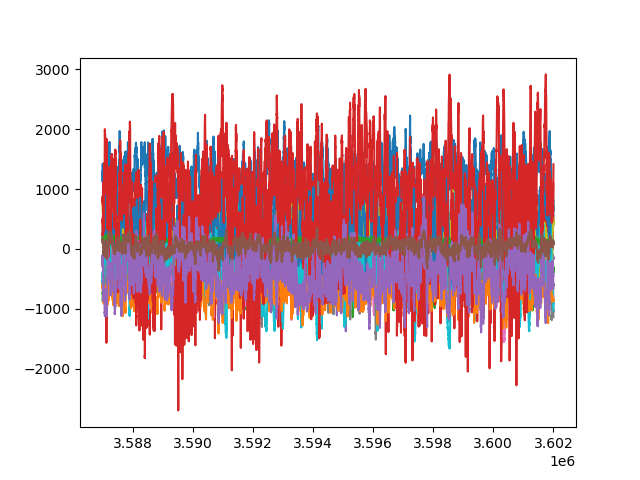

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

KeyError: 'modifiers'

In [ ]:
plt.close()
All3t = All3[3587000:3602000,:]
times = np.arange(3587000, 3602000, 1)
plt.plot(times, All3t)
plt.show()

filename = folder_base / f'plot.svg'
plt.savefig(filename, format="svg")

In [ ]:
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()


sample_rate = 1000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 12], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(All, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00002
view1.by_channel_params['ch1', 'gain'] = 0.0002
view1.by_channel_params['ch2', 'gain'] = 0.0001
view1.by_channel_params['ch3', 'gain'] = 0.0002
view1.by_channel_params['ch4', 'gain'] = 0.0002
view1.by_channel_params['ch5', 'gain'] = 0.0002
view1.by_channel_params['ch6', 'gain'] = 0.00002
view1.by_channel_params['ch7', 'gain'] = 0.00002
view1.by_channel_params['ch8', 'gain'] = 0.0002
view1.by_channel_params['ch9', 'gain'] = 0.0002
view1.by_channel_params['ch10', 'gain'] = 0.0001
view1.by_channel_params['ch11', 'gain'] = 0.0002
view1.by_channel_params['ch12', 'gain'] = 0.0002
view1.by_channel_params['ch13', 'gain'] = 0.00005
view1.by_channel_params['ch14', 'gain'] = 0.0001
view1.by_channel_params['ch15', 'gain'] = 0.0002

view1.by_channel_params['ch0', 'offset'] = 0.8
view1.by_channel_params['ch1', 'offset'] = 0.7
view1.by_channel_params['ch2', 'offset'] = 0.6
view1.by_channel_params['ch3', 'offset'] = 0.5
view1.by_channel_params['ch4', 'offset'] = 0.4
view1.by_channel_params['ch5', 'offset'] = 0.3
view1.by_channel_params['ch6', 'offset'] = 0.2
view1.by_channel_params['ch7', 'offset'] = 0.1
view1.by_channel_params['ch8', 'offset'] = 0
view1.by_channel_params['ch9', 'offset'] = -0.1
view1.by_channel_params['ch10', 'offset'] = -0.2
view1.by_channel_params['ch11', 'offset'] = -0.3
view1.by_channel_params['ch12', 'offset'] = -0.4
view1.by_channel_params['ch13', 'offset'] = -0.5
view1.by_channel_params['ch14', 'offset'] = -0.6
view1.by_channel_params['ch15', 'offset'] = -0.7


#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

NameError: name 'Timestamps' is not defined

In [ ]:
AllC0 = All[:,6]
AllC11 = All[:,22]-All[:,23]
AllC12 = All[:,24]-All[:,25]
AllC13 = All[:,26]-All[:,27]
AllC14 = All[:,28]-All[:,29]
L = [AllC0, AllC12, AllC13, AllC11, AllC14]
All2 = np.concatenate(L, axis=0)
All2 = All2.reshape(5,-1)
All2 = All2.T
All2.shape


from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer

app = mkQApp()


sample_rate = 2000.
t_start = 0.

TTL = Timestamps

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: TTL, 1: TTL}
#and asign them to some channels each
scatter_channels = {0: [0, 2], 1: [0, 1]}
source = AnalogSignalSourceWithScatter(All2, sample_rate, t_start, scatter_indexes, scatter_channels)

#Create the main window that can contain several viewers
win = MainViewer(debug=True, show_auto_scale=True)

#create a viewer for signal with TraceViewer
#connected to the signal source
view1 = TraceViewer(source=source)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.0000002
view1.by_channel_params['ch1', 'gain'] = 0.00002
view1.by_channel_params['ch2', 'gain'] = 0.00002
view1.by_channel_params['ch3', 'gain'] = 0.00002
view1.by_channel_params['ch4', 'gain'] = 0.00002

view1.by_channel_params['ch0', 'offset'] = 0.2
view1.by_channel_params['ch1', 'offset'] = 0.1
view1.by_channel_params['ch2', 'offset'] = 0.0
view1.by_channel_params['ch3', 'offset'] = -0.1
view1.by_channel_params['ch4', 'offset'] = -0.2



#put this viewer in the main window
win.add_view(view1)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  8.797645568847656e-05 s
refresh duration for  0.000797271728515625 s
save_all_settings


0

In [ ]:
AllC0 = All[:,1]
AllC1 = All[:,2]
AllC2 = All[:,29]
AllC3 = All[:,30]

L = [AllC0, AllC1, AllC2, AllC3]
All2 = np.concatenate(L, axis=0)
All2 = All2.reshape(4,-1)
All2 = All2.T
All2.shape

app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(All2, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel

view1.by_channel_params['ch0', 'gain'] = 0.00012
view1.by_channel_params['ch1', 'gain'] = 0.00012
view1.by_channel_params['ch2', 'gain'] = 0.00012
view1.by_channel_params['ch3', 'gain'] = 0.00012

view1.by_channel_params['ch0', 'offset'] = 0.3
view1.by_channel_params['ch1', 'offset'] = 0.1
view1.by_channel_params['ch2', 'offset'] = -0.1
view1.by_channel_params['ch3', 'offset'] = -0.3


view1.by_channel_params['ch0', 'color'] = '#0055ff'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch3', 'color'] = '#0055ff'


#Run
win.show()
app.exec_()


0